ensemble_and_embedding.ipynb에서 k-means clustering ensemble은 ball-shape이 아닌 데이터에 대해서도 clustering을 수행할 수 있었음을 보았다. 정확히는 여러 번의 k-means clustering을 통하여 데이터간의 유사도에 대한 정보를 얻을 수 있고, co-occurrence frequency를 similarity score로 이용하여 hierarchical clustering을 수행하였다. 

k-means ensemble이 어려운 데이터에 대하여 잘 작동할 수 있는 이유는 우리가 원하는 (점들끼리 선으로 연결되는) 데이터의 similarity를 잘 정의하기 때문이다. 

여러 개의 manifold learning / visualization 알고리즘들 (LLE, ISOMAP, t-SNE)을 이용하여 데이터의 공간을 변환도 해보았다. 그 중 LLE, ISOMAP은 모델의 가정이 빙글빙글 데이터에 적합하여 embedding이 잘 되었으나, t-SNE는 얽힌 선처럼 embedding이 되었다. 이 원인에 대해서 이야기해보며 t-SNE의 알고리즘이 잘 작동하는 상황과 그렇지 않는 상황을 이야기해보고자 한다. 

t-SNE는 임베딩하려는 데이터 X의 공간에서 점들 Xi 간의 similarity를 아래와 같은 P(j|i)라는 확률로 정의한다. 

![tsnep](figures/tsne_p.png)

그리고 이를 바탕으로 P_ij = (P(j|i) + P(i|j)) / 2n으로 만든다. 

embedding을 할 공간 Y에서는 Q라는 점들 간의 확률 분포를 만드는데, t-SNE는 X에서 정의된 P와 가장 비슷하게 Q가 만들어지도록 Y를 학습한다. 

![tsneq](figures/tsne_q.png)

이 때, embedding이 잘 되지 않는다면, P와 Q를 맞추는 식이 잘못 되었던지, P 혹은 Q가 embedding에 적합하지 않은 확률모델이기 때문일 것이다. 이를 확인해 보기 위해 Barnes-hut t-SNE[2]가 아닌 Maaten and Hinton (2008)의 t-SNE[1]를 이용하여 확인해보겠다. Barnes-hut t-SNE는 Maaten and Hinton (2008)의 t-SNE의 계산복잡도를 줄이기 위한 근사 알고리즘이기 때문이다. 

- [1] Maaten, L. V. D., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of Machine Learning Research, 9(Nov), 2579-2605.
- [2] Van Der Maaten, L. (2014). Accelerating t-SNE using tree-based algorithms. Journal of machine learning research, 15(1), 3221-3245.

k-means clustering ensemble에 이용하였던 데이터를 그대로 이용할 것이다. 2차원의 데이터를 2차원으로 시각화 하는 것은, 복잡한 구조의 데이터를 단순한 형태로 변환하는 것과 같다. 

In [1]:
from math import sqrt
import numpy as np

n_data = 500
delta = 2 * np.pi / 200
x_delta = 2
def get_r(i, factor=.2):
    return 5 + i * factor

x = []
for i in range(n_data):
    r = get_r(i)
    theta = delta * i
    x.append((r * np.cos(theta), r * np.sin(theta) - x_delta))
x.reverse()
    
for i in range(n_data):
    r = get_r(i)
    theta = delta * i + np.pi
    x.append((r * np.cos(theta), r * np.sin(theta) + x_delta))

x = np.asarray(x)

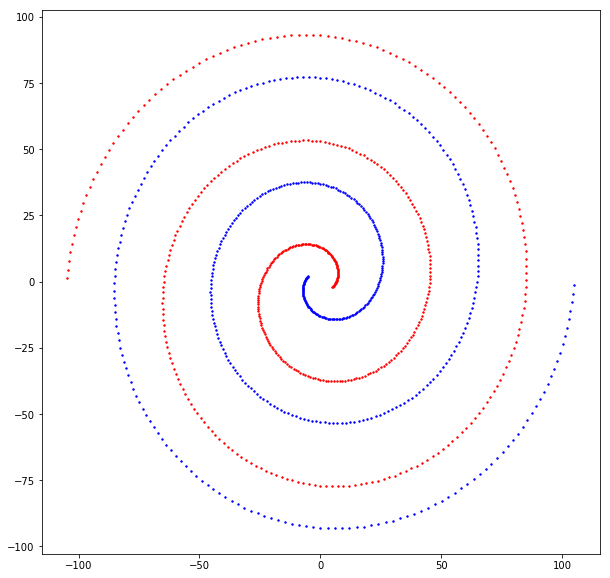

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
plt.scatter(x[:n_data,0], x[:n_data,1], color='red', s=2)
plt.scatter(x[n_data:,0], x[n_data:,1], color='blue', s=2)
plt.show()

In [3]:
import sys
sys.path.append('../')
from soykmeans import KMeansEnsemble
from soykmeans import tsne as tsne_original
from soykmeans import tsne_with_precomputed_P

t-SNE 알고리즘은 [Maaten의 홈페이지][maaten]에서 가져왔으며, 학습의 maximum iteration이 1000으로 되어있는 것을 300으로, Y만 return되는 것을 Y, P, Q가 return 되도록 바꿔두었다. 

tsne_with_precomputed_P는 P를 계산하지 않고 함수에 입력을 받아서 쓰도록 수정하였다. 

[maaten]:https://lvdmaaten.github.io/tsne/

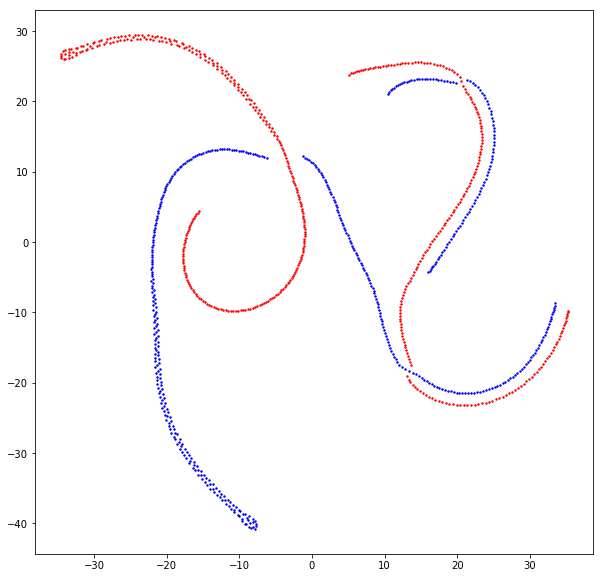

In [4]:
y_tsne, P_tsne, Q_tsne = tsne_original(x, perplexity=30.0)

plt.figure(figsize=(10,10))
plt.scatter(y_tsne[:n_data,0], y_tsne[:n_data,1], color='red', s=2)
plt.scatter(y_tsne[n_data:,0], y_tsne[n_data:,1], color='blue', s=2)
plt.show()

t-SNE의 학습에 이용된 P와 Q 역시 plot을 해보았다. 

Heatmap of t-SNE probability


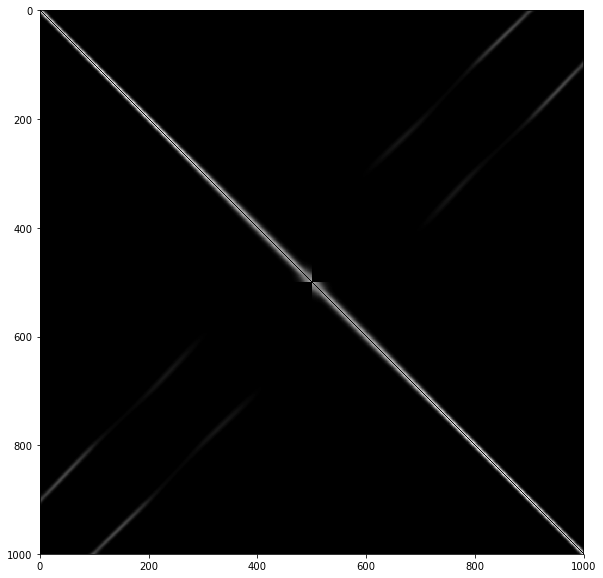

In [5]:
print('Heatmap of t-SNE probability')
plt.figure(figsize=(10,10))
plt.imshow(1-P_tsne, cmap='binary')

Heatmap of t-SNE Q


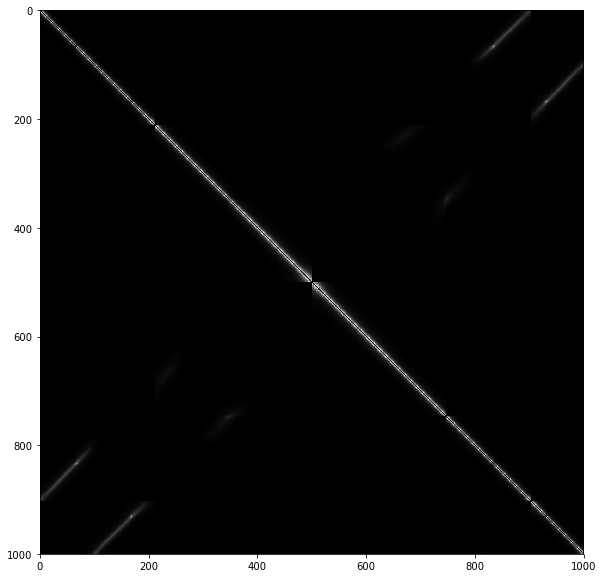

In [6]:
print('Heatmap of t-SNE Q')
plt.figure(figsize=(10,10))
plt.imshow(1-Q_tsne, cmap='binary')

perplexity 때문에 embedding이 제대로 학습되지 않은 것일수도 있으니, 이 역시 바꿔보자. 

하지만 perplexity를 바꿔도 제대로 학습이 되지 않음을 볼 수 있다. 

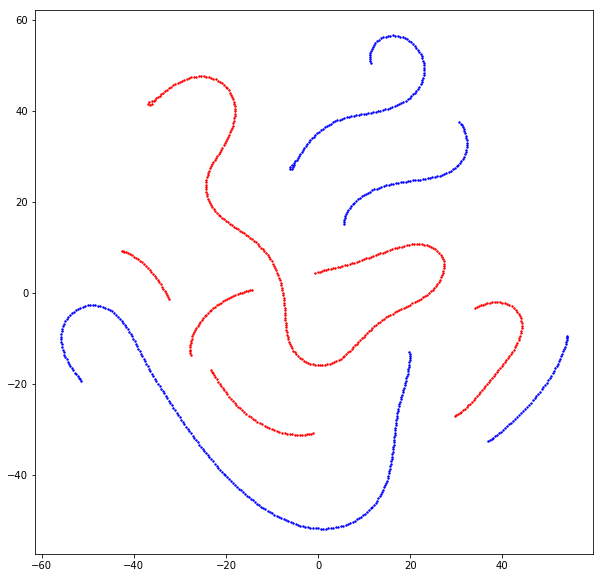

In [11]:
y_tsne_p10, _, _ = tsne_original(x, perplexity=10)

plt.figure(figsize=(10,10))
plt.scatter(y_tsne_p10[:n_data,0], y_tsne_p10[:n_data,1], color='red', s=2)
plt.scatter(y_tsne_p10[n_data:,0], y_tsne_p10[n_data:,1], color='blue', s=2)
plt.show()

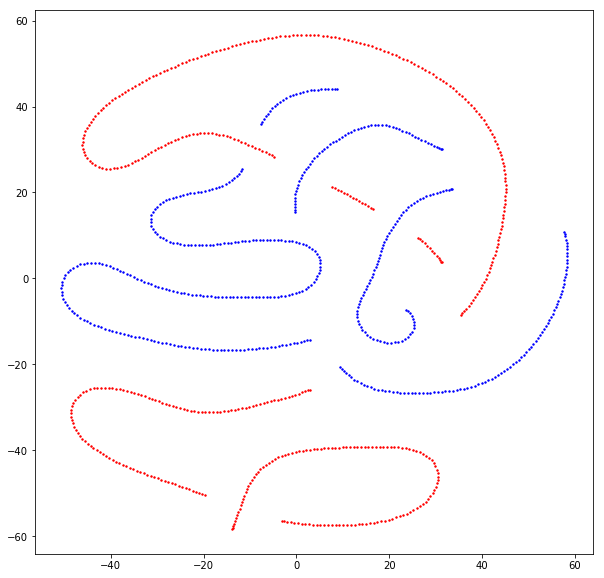

In [7]:
y_tsne_p5, _, _ = tsne_original(x, perplexity=5.0)

plt.figure(figsize=(10,10))
plt.scatter(y_tsne_p5[:n_data,0], y_tsne_p5[:n_data,1], color='red', s=2)
plt.scatter(y_tsne_p5[n_data:,0], y_tsne_p5[n_data:,1], color='blue', s=2)
plt.show()

k-means ensemble은 점들 간의 similarity를 학습하는 것과 같다. co-occurrence frequency를 sum normalize를 하여 마치 P처럼 이용해보자. 

In [12]:
from soykmeans import KMeansEnsemble
kmeans_ensemble = KMeansEnsemble(n_ensembles=500, n_clusters=100)
for _ in kmeans_ensemble.ensemble(x, n_final_clusters=2):
    continue
X = kmeans_ensemble.x_final

Heatmap of coccurrance matrix


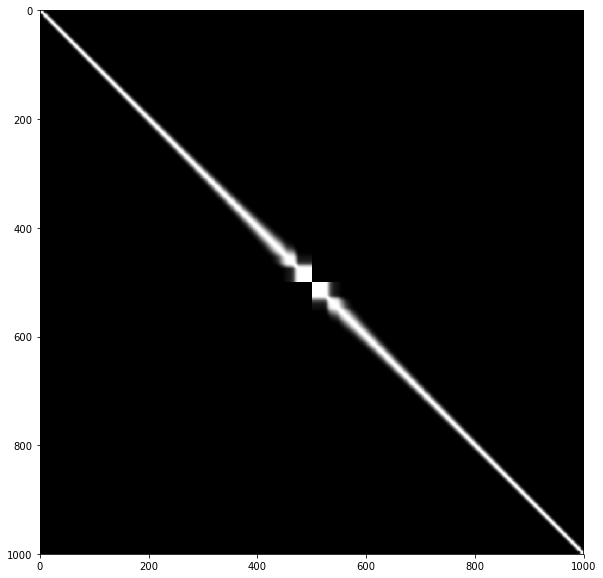

In [13]:
from sklearn.metrics import pairwise_distances

cooccurrance = kmeans_ensemble.x_final
cosine = pairwise_distances(cooccurrance, cooccurrance, metric='cosine')
print('Heatmap of coccurrance matrix')
plt.figure(figsize=(10,10))
plt.imshow(cosine, cmap='binary')

tsne 함수의 input과 동일한 type이 되도록 dense matrix로 만들어주고 symmatric matrix가 되도록 아래 식을 수행한 뒤,

    P = P + Math.transpose(P)
    P = P / Math.sum(P)
    
input type을 numpy.ndarray로 만들어준다. 

    P = Math.asarray(P)

In [14]:
P = X.todense()
P

matrix([[500, 500, 500, ...,   0,   0,   0],
        [500, 500, 500, ...,   0,   0,   0],
        [500, 500, 500, ...,   0,   0,   0],
        ..., 
        [  0,   0,   0, ..., 500, 499, 499],
        [  0,   0,   0, ..., 499, 500, 500],
        [  0,   0,   0, ..., 499, 500, 500]], dtype=int64)

In [15]:
import numpy as Math 

P = P + Math.transpose(P)
P = P / Math.sum(P)
P = P * 4                    # early exaggeration
P = Math.maximum(P, 1e-12)
P = Math.asarray(P)

In [16]:
P

array([[  3.24824871e-04,   3.24824871e-04,   3.24824871e-04, ...,
          1.00000000e-12,   1.00000000e-12,   1.00000000e-12],
       [  3.24824871e-04,   3.24824871e-04,   3.24824871e-04, ...,
          1.00000000e-12,   1.00000000e-12,   1.00000000e-12],
       [  3.24824871e-04,   3.24824871e-04,   3.24824871e-04, ...,
          1.00000000e-12,   1.00000000e-12,   1.00000000e-12],
       ..., 
       [  1.00000000e-12,   1.00000000e-12,   1.00000000e-12, ...,
          3.24824871e-04,   3.24175221e-04,   3.24175221e-04],
       [  1.00000000e-12,   1.00000000e-12,   1.00000000e-12, ...,
          3.24175221e-04,   3.24824871e-04,   3.24824871e-04],
       [  1.00000000e-12,   1.00000000e-12,   1.00000000e-12, ...,
          3.24175221e-04,   3.24824871e-04,   3.24824871e-04]])

co-occurrence frequency를 P로 이용하면, 마치 선처럼 나오던 Y가 골고루 펴진 형태로 학습이 됨을 볼 수 있다. 

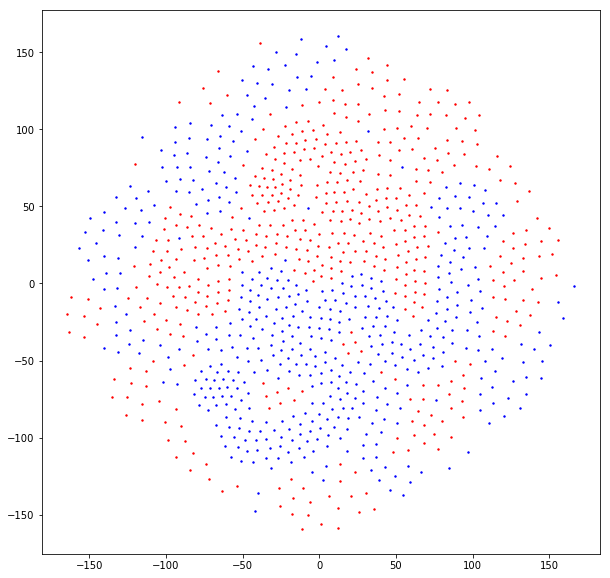

In [19]:
Y, P, Q = tsne_with_precomputed_P(P)

plt.figure(figsize=(10,10))
plt.scatter(Y[:n_data,0], Y[:n_data,1], color='red', s=2)
plt.scatter(Y[n_data:,0], Y[n_data:,1], color='blue', s=2)
plt.show()